In [1]:
pip install transformers accelerate -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.1 MB/s eta 0:00:00


In [2]:
from sklearn.metrics import  accuracy_score, f1_score, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import torch
import pandas as pd
import numpy as np

In [3]:
def tokenize_texts(tokenizer, texts):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
    return encodings

# Load the tokenizer
# tokenizer = AutoTokenizer.from_pretrained('HooshvareLab/bert-fa-base-uncased-clf-persiannews')

In [4]:
# Create PyTorch datasets
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [5]:
# Set up the training arguments
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/IRproject/results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/IRproject/logs',
    logging_steps=100,
    evaluation_strategy='epoch',
    eval_steps=500,
    save_strategy='epoch',
    save_total_limit=1,
    load_best_model_at_end=True,
)


# Evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": accuracy, "f1": f1}

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
model_path = "/content/drive/MyDrive/IRproject/saved_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [8]:
import pandas as pd
import numpy as np
data= pd.read_csv('/content/drive/MyDrive/IRproject/data.csv')
test_texts = data["text"]
test_labels = data["label"]


In [9]:

# Tokenize the new texts
test_encodings = tokenize_texts(tokenizer, test_texts.tolist())

# Create the PyTorch dataset
test_dataset = MyDataset(test_encodings, test_labels.tolist())

# Create a new trainer for evaluation
eval_trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [10]:

# Evaluate the model
eval_results = eval_trainer.evaluate()

# Access the evaluation metrics
test_accuracy = eval_results["eval_accuracy"]
test_f1 = eval_results["eval_f1"]

print(f"Test Accuracy: {test_accuracy}")
print(f"Test F1 Score: {test_f1}")


Test Accuracy: 0.8815238860433197
Test F1 Score: 0.8815711043512695


In [11]:
# Create the confusion matrix
# Make predictions on the test dataset
predictions = eval_trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = test_dataset[:]["labels"].numpy()

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average="weighted")

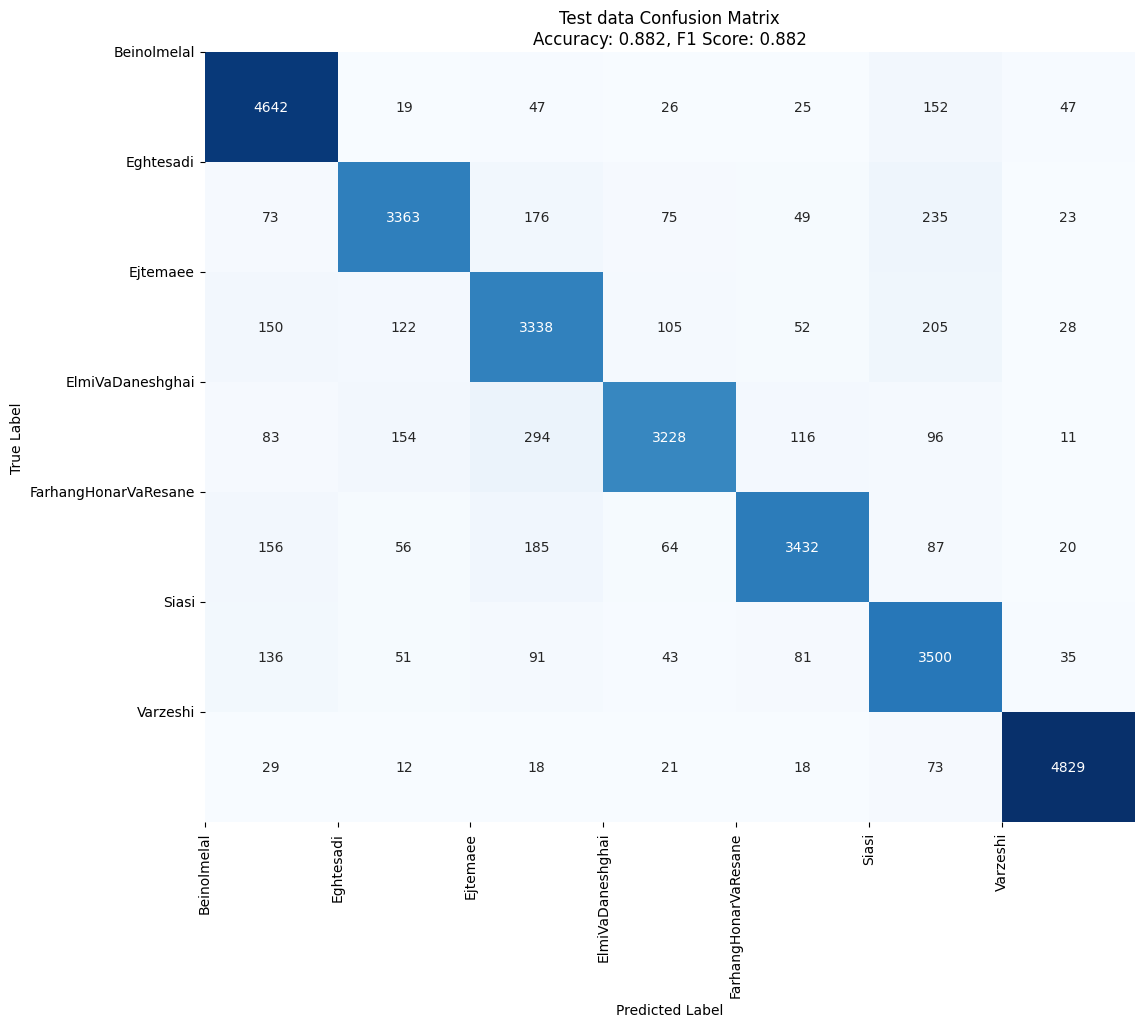

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# Customize the plot
class_names = ['Beinolmelal', 'Eghtesadi', 'Ejtemaee', 'ElmiVaDaneshghai', 'FarhangHonarVaResane', 'Siasi', 'Varzeshi']  # Replace with your class labels

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names, rotation=0)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Test data Confusion Matrix\nAccuracy: {accuracy:.3f}, F1 Score: {f1:.3f}")


# Show the plot
plt.show()